In [1]:
import pandas as pd
from random import randint
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import os
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
import statistics
from mtcnn import MTCNN
from PIL import Image
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
from sklearn.model_selection import train_test_split

In [2]:
landmarks_faces_df = pd.read_csv('outputs\oversampled_faces_with_landmarks_mediapipe.csv')
#parse the landmarks column to a list of tuples
landmarks_faces_df['landmarks'] = landmarks_faces_df['landmarks'].apply(eval)

In [3]:
#Displays the rows with duplicate paths to validate code above works
landmarks_faces_df[landmarks_faces_df.duplicated(subset='pth', keep=False)].sort_values(by='pth')

,index,pth,label,landmarks
4242,4244,augmented/ffhq_1027.png,happy,"[(0.5089619755744934, 0.731025218963623, -0.04..."
6522,6526,augmented/ffhq_1027.png,sad,"[(0.5089619755744934, 0.731025218963623, -0.04..."
3646,3648,augmented/ffhq_1031.png,happy,"[(0.5259443521499634, 0.678326427936554, -0.03..."
6290,6294,augmented/ffhq_1031.png,sad,"[(0.5259443521499634, 0.678326427936554, -0.03..."
3902,3904,augmented/ffhq_1042.png,happy,"[(0.4635147452354431, 0.7055484056472778, -0.0..."
...,...,...,...,...
16715,16741,oversampled/image0042251.jpg,neutral,"[(0.5246935486793518, 0.7083243727684021, -0.0..."
12593,12616,oversampled/image0042343.jpg,anger,"[(0.43755483627319336, 0.8306260704994202, -0...."
12815,12838,oversampled/image0042343.jpg,anger,"[(0.43755483627319336, 0.8306260704994202, -0...."
16460,16486,oversampled/image0042515.jpg,neutral,"[(0.45101094245910645, 0.6387134194374084, -0...."


In [4]:
model_training_df = landmarks_faces_df[['pth', 'label','landmarks']]
model_training_df.reset_index(inplace=True, drop=True)
model_training_df

,pth,label,landmarks
0,anger/image0001956.jpg,happy,"[(0.5075767636299133, 0.6905035972595215, -0.0..."
1,anger/image0004504.jpg,happy,"[(0.506913423538208, 0.6853656768798828, -0.05..."
2,anger/image0006510.jpg,happy,"[(0.5290422439575195, 0.6751238107681274, -0.0..."
3,anger/image0009562.jpg,happy,"[(0.5999926328659058, 0.7471040487289429, -0.0..."
4,anger/image0012970.jpg,happy,"[(0.4938056170940399, 0.7192921042442322, -0.0..."
...,...,...,...
35324,mirrored/oversampled_ffhq_2310.png,neutral,"[(0.5659758448600769, 0.704839289188385, -0.04..."
35325,mirrored/oversampled_ffhq_5002.png,neutral,"[(0.4660402238368988, 0.702263593673706, -0.05..."
35326,mirrored/oversampled_ffhq_2838.png,neutral,"[(0.46601274609565735, 0.7176843881607056, -0...."
35327,mirrored/oversampled_ffhq_4807.png,neutral,"[(0.553207278251648, 0.6844416856765747, -0.08..."


https://github.com/k-m-irfan/simplified_mediapipe_face_landmarks?fbclid=IwAR22kX7xW6mVog_PtG-vvt1aluhH-7RfvikCWVfGDoD19hHBHyPejvZaMGE

In [5]:
left_eyebrow = [70,63,105,66,107,55,65,52,53,46]
right_eyebrow = [300,293,334,296,336,285,295,282,283,276]
left_eye = [33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7]
right_eye =  [263,466,388,387,386,385,384,398,362,382,381,380,374,373,390,249]
inner_lip = [78,191,80,81,82,13,312,311,310,415,308,324,318,402,317,14,87,178,88,95]
outer_lip =  [61,185,40,39,37,0,267,269,270,409,291,375,321,405,314,17,84,181,91,146]
face_boundary = [10,338,297,332,284,251,389,356,454,323,361,288,397,365,379,378,400,377,152,148,176,149,150,136,172,58,132,93,234,127,162,21,54,103,67,109]
left_iris = [468,469,470,471,472]
right_iris = [473,474,475,476,477]
nose = [64,4,294]

combined_points = []
combined_points.extend(left_eyebrow)
combined_points.extend(right_eyebrow)
combined_points.extend(left_eye)
combined_points.extend(right_eye)
combined_points.extend(inner_lip)
combined_points.extend(outer_lip)
combined_points.extend(face_boundary)
combined_points.extend(left_iris)
combined_points.extend(right_iris)
combined_points.extend(nose)

In [6]:
for row in model_training_df.iterrows():
    landmarks = row[1]['landmarks']
    landmarks = [landmarks[i] for i in combined_points]
    model_training_df.at[row[0], 'landmarks'] = landmarks

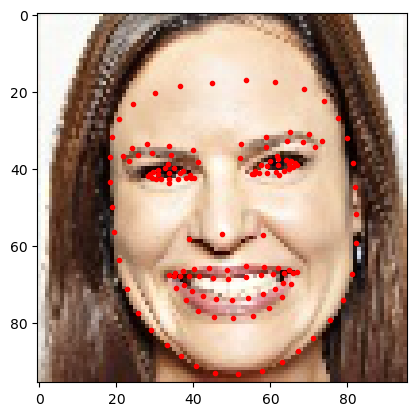

In [7]:
# Load the image
image_path = "./dataset/" + model_training_df['pth'][0]
image = mpimg.imread(image_path)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Get the landmarks
landmarks = model_training_df['landmarks'][0]

# Plot the landmarks as points
for landmark in landmarks:
    x, y, _ = landmark
    ax.plot(x * 96, y * 96, 'ro', markersize=3)

# Show the plot
plt.show()


#display the resulting coordinates of each landmark

In [8]:
# Extract x, y, and z coordinates from the tuples in the 'landmarks' column
coordinates = model_training_df['landmarks'].apply(lambda x: [coord for landmark in x for coord in landmark])

# Create a DataFrame from the extracted coordinates
landmarks_df = pd.DataFrame(coordinates.tolist(), columns=[f'lm_{i+1}_{coord}' for i in range(len(coordinates.iloc[0]) // 3) for coord in ['x', 'y', 'z']])

# Concatenate the original DataFrame with the new landmarks DataFrame
model_training_df = pd.concat([model_training_df, landmarks_df], axis=1)

# Drop the original 'landmarks' column
model_training_df.drop(columns=['landmarks', 'pth'], inplace=True)
model_training_df.head()

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
0,happy,0.226219,0.381799,0.038242,0.250068,0.361314,-0.008271,0.292014,0.350517,-0.044980,...,-0.007774,0.403663,0.608458,-0.067300,0.493527,0.593167,-0.181729,0.604648,0.596916,-0.079903
1,happy,0.246005,0.348122,-0.051194,0.283079,0.332501,-0.078546,0.327581,0.327949,-0.095936,...,0.030347,0.432196,0.600044,-0.079112,0.533977,0.598784,-0.150699,0.580798,0.609539,-0.042294
2,happy,0.257999,0.383563,0.002389,0.283292,0.362782,-0.032297,0.322953,0.348970,-0.058516,...,0.001229,0.444767,0.598483,-0.056526,0.518412,0.577950,-0.142952,0.589326,0.579395,-0.052673
3,happy,0.207841,0.427158,-0.052541,0.249446,0.397158,-0.077840,0.304518,0.374407,-0.092454,...,0.072984,0.479263,0.637998,-0.092606,0.610292,0.589869,-0.167392,0.666678,0.605170,-0.038013
4,happy,0.244650,0.352717,0.059794,0.270829,0.328296,0.025753,0.314433,0.316996,-0.002371,...,0.028702,0.417333,0.594563,-0.060003,0.505565,0.570643,-0.153477,0.597533,0.610524,-0.062293


In [9]:
model_training_df.to_csv('outputs/simplified_landmarks.csv', index=False, header=True, encoding='utf-8')

In [10]:
#Splitting of data into train and test sets, 
train_set = model_training_df.sample(frac=0.8)
train_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
5006,sad,0.243052,0.369918,-0.105113,0.288735,0.345682,-0.127784,0.341963,0.335293,-0.140595,...,0.007951,0.446726,0.645312,-0.072472,0.560845,0.619336,-0.132431,0.596199,0.632577,-0.018558
2493,happy,0.286553,0.413192,0.043043,0.305128,0.397455,0.011072,0.332909,0.389997,-0.016375,...,0.003947,0.421395,0.613348,-0.055646,0.488504,0.601951,-0.140345,0.564248,0.611161,-0.062190
5941,sad,0.164987,0.341429,0.033198,0.191289,0.316625,-0.016259,0.238710,0.307991,-0.055835,...,-0.017063,0.377334,0.613628,-0.081608,0.477423,0.586973,-0.205557,0.594569,0.609898,-0.089813
27077,anger,0.161512,0.404106,-0.002196,0.195136,0.375952,-0.037877,0.246646,0.355331,-0.062234,...,0.040686,0.401505,0.605414,-0.072086,0.507888,0.565325,-0.163224,0.585711,0.574820,-0.048397
34476,neutral,0.243616,0.490936,0.057884,0.257135,0.452555,0.034645,0.286363,0.421388,0.013965,...,0.051971,0.484052,0.619026,-0.065011,0.538853,0.550651,-0.134753,0.608991,0.569862,-0.052678
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
591,happy,0.275923,0.411709,-0.008925,0.298196,0.397137,-0.039943,0.332104,0.391273,-0.064961,...,-0.011990,0.437633,0.649752,-0.040851,0.504053,0.636146,-0.119482,0.567161,0.647545,-0.038963
3492,happy,0.271503,0.422980,0.043637,0.296841,0.396201,0.018824,0.335462,0.380269,-0.001975,...,0.042607,0.426731,0.590879,-0.065479,0.511772,0.561562,-0.136295,0.578070,0.594959,-0.053813
5820,sad,0.194965,0.332648,0.097099,0.228732,0.292933,0.058686,0.279448,0.265621,0.025400,...,0.053041,0.410894,0.621798,-0.073901,0.499205,0.556710,-0.178643,0.587365,0.623235,-0.071620
3581,happy,0.275196,0.445663,0.071211,0.291390,0.421768,0.040480,0.319616,0.406298,0.012346,...,0.011506,0.429708,0.630712,-0.046660,0.489469,0.598557,-0.132335,0.575068,0.611000,-0.060587


In [11]:
test_set = pd.concat([model_training_df,train_set]).drop_duplicates(keep=False)
test_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_138_z,lm_139_x,lm_139_y,lm_139_z,lm_140_x,lm_140_y,lm_140_z,lm_141_x,lm_141_y,lm_141_z
3,happy,0.207841,0.427158,-0.052541,0.249446,0.397158,-0.077840,0.304518,0.374407,-0.092454,...,0.072984,0.479263,0.637998,-0.092606,0.610292,0.589869,-0.167392,0.666678,0.605170,-0.038013
14,happy,0.294301,0.412844,0.098371,0.304432,0.391542,0.061842,0.325369,0.377782,0.027234,...,-0.015569,0.391587,0.629452,-0.042867,0.441692,0.601849,-0.141174,0.548979,0.625148,-0.078085
20,happy,0.246525,0.321810,-0.078775,0.290492,0.299129,-0.114281,0.346424,0.286425,-0.139784,...,0.002694,0.441087,0.615499,-0.066547,0.556802,0.607764,-0.154507,0.615264,0.614899,-0.033336
21,happy,0.217589,0.364185,-0.014838,0.241245,0.342264,-0.057201,0.280000,0.326760,-0.091014,...,-0.001676,0.426119,0.614159,-0.055244,0.520120,0.597505,-0.160186,0.608256,0.583230,-0.053283
23,happy,0.164340,0.356398,-0.018963,0.203008,0.323254,-0.061714,0.261160,0.298875,-0.090613,...,0.027649,0.423200,0.614284,-0.098031,0.556574,0.575104,-0.208170,0.651104,0.600559,-0.071470
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35296,neutral,0.191135,0.237120,0.031330,0.228589,0.213849,-0.017328,0.280645,0.208135,-0.056963,...,0.004447,0.348511,0.617055,-0.068857,0.444250,0.595785,-0.192212,0.536449,0.650053,-0.069122
35300,neutral,0.319695,0.341893,0.087654,0.341282,0.324483,0.052740,0.373991,0.316708,0.023168,...,0.014327,0.413731,0.558450,-0.045354,0.479573,0.533246,-0.135318,0.556602,0.580762,-0.062900
35303,neutral,0.303098,0.359674,0.028591,0.332309,0.342821,0.002461,0.369429,0.335559,-0.019071,...,0.020695,0.407209,0.611315,-0.049905,0.481565,0.592153,-0.122091,0.536967,0.636595,-0.044345
35313,neutral,0.308434,0.375892,0.019520,0.327328,0.367571,-0.016187,0.358332,0.369528,-0.047132,...,-0.030084,0.398634,0.585848,-0.035666,0.452111,0.585416,-0.124202,0.521738,0.618270,-0.049547


In [12]:
# Exporting Datasets
train_set.to_csv('outputs/train_set_augmented_simplified.csv', index=False, header=True, encoding='utf-8')

In [13]:
# Exporting Datasets
test_set.to_csv('outputs/test_set_augmented_simplified.csv', index=False, header=True, encoding='utf-8')

In [14]:
left_face_landmarks_mid = [151, 9, 8, 168, 6, 197, 195, 5, 4, 1, 19, 94, 2, 164, 0, 11, 12, 13, 14, 15, 16, 17, 18, 200, 199, 175]
left_face_landmarks_lips = [37, 39, 40, 72, 73, 74, 38, 41, 42, 82, 81, 80, 185, 184, 183, 191, 61, 76, 67, 78, 95, 88, 178, 87, 96, 89, 179, 86, 77, 90, 180, 85, 146, 91, 181, 84]
left_face_left_eye = [33,246,161,160,159,158,157,173,133,155,154,153,145,144,163,7]
left_face_left_eyebrow = [70,63,105,66,107,55,65,52,53,46]
left_face_border = [10, 109, 67, 103, 54, 21, 162, 127, 237, 137, 93, 177, 132, 215, 58, 172, 136, 150, 149, 176, 148, 152]
left_face_nose_cluster = [45, 220, 115, 102, 129, 48, 218, 219, 64, 235, 166, 79, 237, 59, 239, 98, 240, 75, 239, 44, 60, 99, 97, 238, 20, 241, 242, 125, 141]
left_face_upper = [108, 69, 104, 68, 71, 139, 156, 124, 225, 224, 223, 221, 221, 193, 189, 190, 56, 28, 27, 29, 30, 247, 113, 130, 25, 110, 24, 23, 22, 26, 112, 243, 244, 245, 233, 232, 231, 230, 229, 228, 31, 35, 122, 188, 128, 121, 120, 100, 47, 114, 196, 174, 217, 126, 142, 209, 198, 236, 3, 131, 134, 51, 34, 143, 116, 111, 117, 118, 119, 101, 36, 50, 123]
left_face_lower = [205, 206, 203, 92, 165, 167, 147, 187, 213, 207, 192, 216, 186, 138, 214, 212, 57, 135, 210, 202, 43, 169, 106, 204, 211, 170, 182, 194, 32, 140, 83, 201, 208, 171]

combined_points_left = []
combined_points_left.extend(left_face_landmarks_mid)
combined_points_left.extend(left_face_landmarks_lips)
combined_points_left.extend(left_face_left_eye)
combined_points_left.extend(left_face_left_eyebrow)
combined_points_left.extend(left_face_border)
combined_points_left.extend(left_face_nose_cluster)
combined_points_left.extend(left_face_upper)
combined_points_left.extend(left_face_lower)
    

In [15]:
model_training_df = landmarks_faces_df[['pth', 'label','landmarks']]
model_training_df.reset_index(inplace=True, drop=True)
model_training_df

,pth,label,landmarks
0,anger/image0001956.jpg,happy,"[(0.5075767636299133, 0.6905035972595215, -0.0..."
1,anger/image0004504.jpg,happy,"[(0.506913423538208, 0.6853656768798828, -0.05..."
2,anger/image0006510.jpg,happy,"[(0.5290422439575195, 0.6751238107681274, -0.0..."
3,anger/image0009562.jpg,happy,"[(0.5999926328659058, 0.7471040487289429, -0.0..."
4,anger/image0012970.jpg,happy,"[(0.4938056170940399, 0.7192921042442322, -0.0..."
...,...,...,...
35324,mirrored/oversampled_ffhq_2310.png,neutral,"[(0.5659758448600769, 0.704839289188385, -0.04..."
35325,mirrored/oversampled_ffhq_5002.png,neutral,"[(0.4660402238368988, 0.702263593673706, -0.05..."
35326,mirrored/oversampled_ffhq_2838.png,neutral,"[(0.46601274609565735, 0.7176843881607056, -0...."
35327,mirrored/oversampled_ffhq_4807.png,neutral,"[(0.553207278251648, 0.6844416856765747, -0.08..."


In [16]:
for row in model_training_df.iterrows():
    landmarks = row[1]['landmarks']
    landmarks = [landmarks[i] for i in combined_points_left]
    model_training_df.at[row[0], 'landmarks'] = landmarks

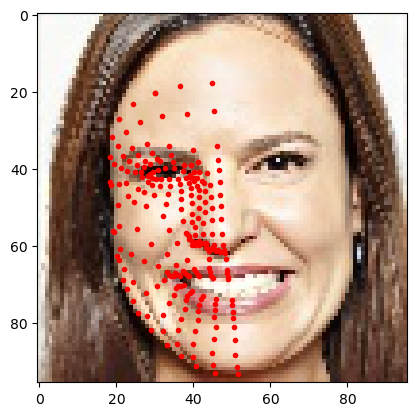

In [17]:
# Load the image
image_path = "./dataset/" + model_training_df['pth'][0]
image = mpimg.imread(image_path)

# Create a figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(image)

# Get the landmarks
landmarks = model_training_df['landmarks'][0]

# Plot the landmarks as points
for landmark in landmarks:
    x, y, _ = landmark
    ax.plot(x * 96, y * 96, 'ro', markersize=3)

# Show the plot
plt.show()


#display the resulting coordinates of each landmark

In [18]:
# Extract x, y, and z coordinates from the tuples in the 'landmarks' column
coordinates = model_training_df['landmarks'].apply(lambda x: [coord for landmark in x for coord in landmark])

# Create a DataFrame from the extracted coordinates
landmarks_df = pd.DataFrame(coordinates.tolist(), columns=[f'lm_{i+1}_{coord}' for i in range(len(coordinates.iloc[0]) // 3) for coord in ['x', 'y', 'z']])

# Concatenate the original DataFrame with the new landmarks DataFrame
model_training_df = pd.concat([model_training_df, landmarks_df], axis=1)

# Drop the original 'landmarks' column
model_training_df.drop(columns=['landmarks', 'pth'], inplace=True)
model_training_df.head()

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_243_z,lm_244_x,lm_244_y,lm_244_z,lm_245_x,lm_245_y,lm_245_z,lm_246_x,lm_246_y,lm_246_z
0,happy,0.473658,0.261993,-0.099915,0.480845,0.356072,-0.104402,0.483735,0.392341,-0.093549,...,0.011211,0.472879,0.876481,0.021271,0.468348,0.915415,0.027220,0.469180,0.947742,0.044293
1,happy,0.526058,0.320098,-0.090309,0.522026,0.373981,-0.091706,0.518243,0.410567,-0.081092,...,0.025584,0.436388,0.831007,0.035614,0.427855,0.857709,0.038037,0.421710,0.882590,0.051508
2,happy,0.481793,0.267251,-0.089710,0.490914,0.348024,-0.090238,0.493959,0.382012,-0.079734,...,0.011752,0.497107,0.814360,0.020247,0.493939,0.847113,0.024791,0.494543,0.872473,0.039547
3,happy,0.508892,0.280521,-0.061310,0.528640,0.357668,-0.074109,0.535282,0.396106,-0.067197,...,-0.043563,0.568307,0.879690,-0.038823,0.568481,0.924591,-0.039270,0.568897,0.963173,-0.024857
4,happy,0.517191,0.277065,-0.025698,0.515960,0.354185,-0.043776,0.515340,0.389386,-0.042554,...,-0.051817,0.448840,0.834760,-0.046515,0.439707,0.868215,-0.045022,0.432530,0.900748,-0.033704


In [19]:
#Splitting of data into train and test sets, 
train_set = model_training_df.sample(frac=0.8)
train_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_243_z,lm_244_x,lm_244_y,lm_244_z,lm_245_x,lm_245_y,lm_245_z,lm_246_x,lm_246_y,lm_246_z
26723,anger,0.495573,0.280325,-0.023186,0.492584,0.358813,-0.047452,0.490659,0.393580,-0.044978,...,-0.053043,0.420375,0.848374,-0.053356,0.406652,0.888268,-0.056717,0.397763,0.923350,-0.045198
5752,sad,0.491145,0.236139,-0.131424,0.490254,0.324398,-0.125978,0.489483,0.364218,-0.109485,...,0.037755,0.445798,0.846227,0.054807,0.438250,0.873604,0.065882,0.437196,0.895172,0.089406
16325,neutral,0.445752,0.334057,-0.036046,0.456445,0.394790,-0.048864,0.463079,0.429630,-0.044699,...,-0.019301,0.499606,0.844195,-0.014237,0.497490,0.875078,-0.011692,0.500483,0.899658,0.000548
17657,neutral,0.543017,0.339965,-0.079975,0.521685,0.406879,-0.080049,0.511675,0.437987,-0.069470,...,0.007898,0.361602,0.786550,0.018390,0.347446,0.807749,0.024849,0.339055,0.824635,0.041213
17010,neutral,0.468680,0.324910,0.006931,0.471449,0.390637,-0.016269,0.473290,0.423505,-0.017848,...,-0.039756,0.455952,0.844790,-0.039519,0.448888,0.872662,-0.041200,0.448536,0.895995,-0.034419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29527,anger,0.489136,0.269994,-0.038116,0.491961,0.345756,-0.055549,0.492663,0.381346,-0.054150,...,-0.023700,0.426788,0.920821,-0.010266,0.424071,0.939651,-0.008789,0.420670,0.965040,0.000227
1829,happy,0.509669,0.350248,-0.094687,0.510146,0.405372,-0.093412,0.509573,0.436280,-0.082168,...,0.010357,0.459923,0.829513,0.021813,0.451541,0.862567,0.028466,0.446983,0.891059,0.045587
15472,neutral,0.461694,0.193475,-0.102306,0.461755,0.279519,-0.103942,0.462256,0.326101,-0.090888,...,0.015278,0.424660,0.887364,0.030469,0.416060,0.919974,0.040829,0.413768,0.947792,0.062686
34901,neutral,0.436012,0.257437,-0.086144,0.463200,0.328542,-0.088447,0.476503,0.367464,-0.077500,...,0.004194,0.580236,0.812857,0.012071,0.582237,0.845237,0.015649,0.585437,0.870070,0.032886


In [20]:
test_set = pd.concat([model_training_df,train_set]).drop_duplicates(keep=False)
test_set

,label,lm_1_x,lm_1_y,lm_1_z,lm_2_x,lm_2_y,lm_2_z,lm_3_x,lm_3_y,lm_3_z,...,lm_243_z,lm_244_x,lm_244_y,lm_244_z,lm_245_x,lm_245_y,lm_245_z,lm_246_x,lm_246_y,lm_246_z
3,happy,0.508892,0.280521,-0.061310,0.528640,0.357668,-0.074109,0.535282,0.396106,-0.067197,...,-0.043563,0.568307,0.879690,-0.038823,0.568481,0.924591,-0.039270,0.568897,0.963173,-0.024857
4,happy,0.517191,0.277065,-0.025698,0.515960,0.354185,-0.043776,0.515340,0.389386,-0.042554,...,-0.051817,0.448840,0.834760,-0.046515,0.439707,0.868215,-0.045022,0.432530,0.900748,-0.033704
20,happy,0.565584,0.239177,-0.158353,0.561012,0.314114,-0.140281,0.556071,0.357632,-0.120230,...,0.044249,0.458034,0.797593,0.060385,0.447597,0.825525,0.071443,0.440810,0.844089,0.095992
26,happy,0.427854,0.261546,-0.222509,0.444436,0.365391,-0.196464,0.452353,0.402529,-0.169406,...,0.105761,0.543017,0.917809,0.138140,0.538867,0.956698,0.165551,0.543012,0.987354,0.199632
30,happy,0.452889,0.271014,-0.055722,0.464855,0.351958,-0.069770,0.471369,0.389812,-0.064000,...,-0.019857,0.498926,0.875204,-0.012618,0.494905,0.913990,-0.008388,0.496813,0.946017,0.007108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35226,neutral,0.505463,0.337007,-0.043781,0.505736,0.391256,-0.050417,0.505004,0.425628,-0.044420,...,-0.016472,0.462178,0.762636,-0.013440,0.454568,0.783686,-0.013317,0.450755,0.799481,-0.001606
35233,neutral,0.447904,0.316726,-0.015389,0.457909,0.375309,-0.029667,0.464293,0.411438,-0.028090,...,-0.029154,0.489625,0.831416,-0.023764,0.487827,0.861394,-0.020357,0.491148,0.885443,-0.009662
35239,neutral,0.478635,0.341023,-0.071596,0.487617,0.394630,-0.071386,0.492375,0.428148,-0.061811,...,0.007005,0.504986,0.774690,0.013880,0.500907,0.795734,0.017813,0.499994,0.811359,0.032485
35272,neutral,0.508651,0.328887,-0.038537,0.516994,0.399248,-0.053676,0.518036,0.430118,-0.048861,...,-0.032032,0.500287,0.835797,-0.031399,0.492652,0.868385,-0.034758,0.487166,0.895398,-0.023305


In [21]:
# Exporting Datasets
train_set.to_csv('outputs/train_set_augmented_left.csv', index=False, header=True, encoding='utf-8')

In [22]:
# Exporting Datasets
test_set.to_csv('outputs/test_set_augmented_left.csv', index=False, header=True, encoding='utf-8')